In [1]:
from azure.storage.blob import ContainerClient
import json
import os
from PIL import Image
import requests
import time
import uuid
from langchain_huggingface import HuggingFaceEndpoint
from langchain_openai import AzureChatOpenAI, ChatOpenAI
from langchain_aws.chat_models.bedrock import ChatBedrock
from langchain_core.prompts import ChatPromptTemplate,MessagesPlaceholder
from langchain.memory import ChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain.tools import tool
from langchain_experimental.tools.python.tool import PythonREPLTool


In [37]:
# Set Hugging Face API token. This has to be a token type: *Read*
huggingfacehub_api_token = os.environ["HUGGINGFACEHUB_API_TOKEN"]

# Variables for Azure blob-storage connection
CONNECTION_STRING = os.environ["CONNECTION_STRING"]
CONTAINER_NAME= os.environ["CONTAINER_NAME"]
# Leonardo image generation token
LEO_IMG_TOKEN= os.environ["LEO_IMG_TOKEN"]
LEO_MODEL_ID = os.environ["LEO_MODEL_ID"]
LEO_STYLE_UUID = os.environ["LEO_STYLE_UUID"]
# OpenAI Key
OPENAI_KEY = os.environ["OPENAI_KEY"]

# AWS credentials to access antropic model in AWS Bedrock
aws_access_key_id = os.environ["AWS_ACCESS_KEY_ID"]
aws_access_key_secret = os.environ["AWS_ACCESS_KEY_SECRET"]
aws_region = os.environ["AWS_REGION"]
aws_model_id = os.environ["AWS_MODEL_ID"]

# Azure OpenAI model identifiers
azure_deployment = os.environ["AZURE_DEPLOYMENT"]  # or your deployment
azure_api_version = os.environ["AZURE_MODEL_VERSION"] # or your api version
azure_openai_key = os.environ["AZURE_OPENAI_KEY"]
azure_endpoint = os.environ["AZURE_ENDPOINT"]

In [5]:
# Define the LLM
hf_llm = HuggingFaceEndpoint(
    repo_id="meta-llama/Llama-3.2-1B", # need to use HF token which has read access to Llama-3.2 model
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
    huggingfacehub_api_token=huggingfacehub_api_token
)

/Users/vermaa/Desktop/agent-chatbot/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
CONTAINER_CLIENT = ContainerClient.from_connection_string(conn_str=CONNECTION_STRING, container_name=CONTAINER_NAME)
def ingest(file_path: str, blob_path: str):
    try:
        _BLOB_CLIENT = CONTAINER_CLIENT.get_blob_client(blob=blob_path)
        with open(file_path, "rb") as data:
            _BLOB_CLIENT.upload_blob(data=data, overwrite=True)
    except Exception as err:
        print("/"*10  + f" {err} or, \n {blob_path} already exists azure-blob-storage " + "\\"*10)

In [7]:
def generate_leo_img(prompt: str):
    ID= str(uuid.uuid4().hex)
    #image generation
    url = "https://cloud.leonardo.ai/api/rest/v1/generations"
    headers = {
        "accept": "application/json",
        "authorization": f"Bearer {LEO_IMG_TOKEN}",
        "content-type": "application/json"
    }
    # Define the data payload
    payload = {
        "height": 512,
        "prompt": prompt,
        "modelId": LEO_MODEL_ID,  # Leonardo Phoenix Model
        "width": 512,
        "alchemy": True,
        "contrast": 4,
        "styleUUID": LEO_STYLE_UUID,
        "public": False,
        "num_images": 1,
        "enhancePrompt": False
    }
    response = requests.post(url, headers=headers, json=payload)
    time.sleep(2) 

    generation_id = response.json()["sdGenerationJob"]["generationId"]
    credit_cost = response.json()["sdGenerationJob"]["apiCreditCost"] 
  
    # get the generated image
    url = f"https://cloud.leonardo.ai/api/rest/v1/generations/{generation_id}"
    flag = True
    while flag:
        try:
            response = requests.get(url, headers=headers)
            time.sleep(5)
            image_url = response.json()["generations_by_pk"]["generated_images"][0]["url"]
            flag = False
        except IndexError as e:
            print("wait")
        except Exception as e:
            print("wait")
            flag = False        

    im = Image.open(requests.get(image_url, stream=True).raw)
    im.save(f"{ID}_Leo.png")
    blob_path = f"OpenAI-Assistant/{ID}_Leo.png"
    ingest(file_path=f"{ID}_Leo.png", blob_path=blob_path)
    if os.path.exists(f"{ID}_Leo.png"):
        os.remove(f"{ID}_Leo.png")
    print(generation_id)
    return blob_path

In [39]:
openai_llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    api_key=OPENAI_KEY,  # if you prefer to pass api key in directly instaed of using env vars
    # base_url="...",
    # organization="...",
    # other params...
)

In [ ]:
claude_llm = ChatBedrock(
    model_id=aws_model_id,
    temperature=0,
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_access_key_secret,
    region_name=aws_region
)

In [10]:
azure_llm = AzureChatOpenAI(
    azure_deployment=azure_deployment,  # or your deployment
    api_version=azure_api_version,  # or your api version
    temperature=0,
    max_tokens=None,
    timeout=None,
    api_key=azure_openai_key,
    max_retries=2,
    azure_endpoint=azure_endpoint
    # other params...
)

In [11]:
messages = [
    (
        "system",
        "You are a helpful assistant. Answer the questions in sarcastic way.",
    ),
    ("human", "I love programming."),
]
ai_msg = azure_llm.invoke(messages)
ai_msg

AIMessage(content="Oh, really? I couldn't tell at all! It's not like every programmer ever has said that. How original!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 29, 'total_tokens': 52, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_65792305e4', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sex

In [30]:



python_tool=PythonREPLTool(description= 'A Python shell. Use this to execute python code. Also, use this to perform some analysis on data like create graphs.')

@tool
def multiply_numbers(num1: int, num2: int) -> int:
    """
    multiplication of numbers
    """
    return num1 * num2


@tool
def generate_image(prompt: str) -> str:
    """
    generate an image of given prompt
    """
    return generate_leo_img(prompt)

chat_history_for_chain = ChatMessageHistory()



def call_chain(model, question):
    messages = ChatPromptTemplate.from_messages([
        ("system", "You are a helpful assistant. Answer the questions and alway give image path when user ask to generate an image. For python_tool always write a python code for it to produce output ans store any generated documents into result folder if not present create one."),
        ("placeholder", "{chat_history}"),
        ("human", "{input}"),
        ("placeholder", "{agent_scratchpad}"),
        ])

    chain = messages | model

    tools = [multiply_numbers, generate_image, python_tool]

    agent = create_tool_calling_agent(model, tools, messages)

    agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True, handle_parsing_errors=True)
    
    # agent_with_chat_history = RunnableWithMessageHistory(
    #     agent_executor,
    #     lambda session_id: chat_history_for_chain,
    #     input_messages_key="input",
    #     history_messages_key="chat_history",
    # )

    # ai_msg= agent_with_chat_history.invoke(
    # {"input": question},
    # {"configurable": {"session_id": "session1"}},
    # )

    ai_msg= agent_executor.invoke({"input": question, "chat_history":chat_history_for_chain.messages})
    chat_history_for_chain.add_user_message(question)
    if model== claude_llm:
        chat_history_for_chain.add_ai_message(ai_msg['output'])
        # chat_history_for_chain.add_ai_message(ai_msg['output'][0]['text'])
        return ai_msg['output'] # [0]['text']
    else:
        chat_history_for_chain.add_ai_message(ai_msg['output'])
        return ai_msg['output']
    




> Entering new AgentExecutor chain...


Python REPL can execute arbitrary code. Use with caution.



Invoking: `Python_REPL` with `{'query': "import matplotlib.pyplot as plt\nimport pandas as pd\n\n# Sample dataset\ndata = {\n    'Month': ['January', 'February', 'March', 'April', 'May'],\n    'Sales (in units)': [150, 200, 175, 225, 190]\n}\ndf = pd.DataFrame(data)\n\n# Create bar chart\nplt.figure(figsize=(10, 6))\nplt.bar(df['Month'], df['Sales (in units)'], color='skyblue')\nplt.xlabel('Month')\nplt.ylabel('Sales (in units)')\nplt.title('Sales Trends Over Five Months')\nplt.savefig('result/sales_trends_bar_chart.png')\nplt.show()"}`
responded: Let's create a bar chart to visualize the sales trends over these five months.

I'll generate the graph using Python.

FileNotFoundError(2, 'No such file or directory')

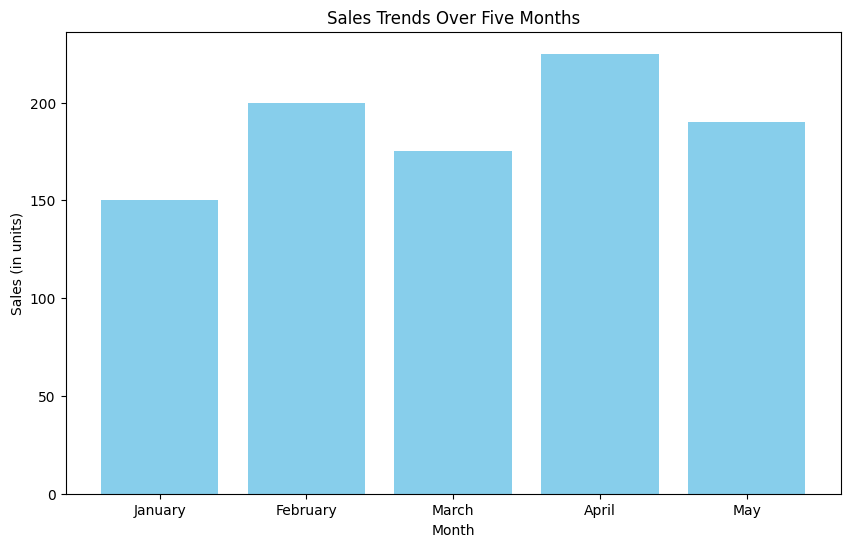

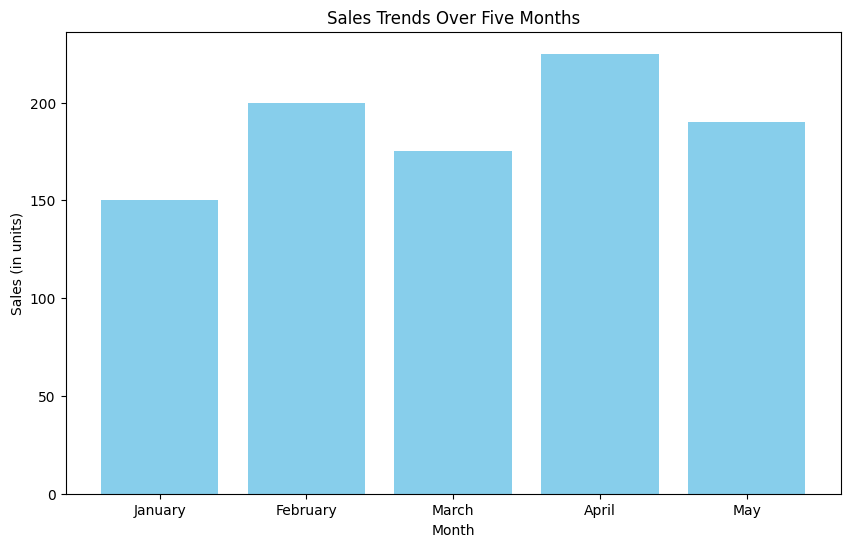


Invoking: `Python_REPL` with `{'query': "import os\nimport matplotlib.pyplot as plt\nimport pandas as pd\n\n# Create result directory if it doesn't exist\nos.makedirs('result', exist_ok=True)\n\n# Sample dataset\ndata = {\n    'Month': ['January', 'February', 'March', 'April', 'May'],\n    'Sales (in units)': [150, 200, 175, 225, 190]\n}\ndf = pd.DataFrame(data)\n\n# Create bar chart\nplt.figure(figsize=(10, 6))\nplt.bar(df['Month'], df['Sales (in units)'], color='skyblue')\nplt.xlabel('Month')\nplt.ylabel('Sales (in units)')\nplt.title('Sales Trends Over Five Months')\nplt.savefig('result/sales_trends_bar_chart.png')\nplt.show()"}`


The bar chart has been successfully generated and saved.

You can find the image at the following path: `result/sales_trends_bar_chart.png`

> Finished chain.


'The bar chart has been successfully generated and saved.\n\nYou can find the image at the following path: `result/sales_trends_bar_chart.png`'

In [32]:
call_chain(azure_llm, """Here's a sample dataset with 5 entries that you can use to generate a graph. Let's assume it's sales data of a product over five months:

| Month    | Sales (in units) |
|----------|------------------|
| January  | 150              |
| February | 200              |
| March    | 175              |
| April    | 225              |
| May      | 190              |

You could use this data to create a line graph, bar chart, or pie chart showing sales trends over these months. Let me know if you'd like a specific type of graph!""")

In [33]:
chat_history_for_chain.messages

[HumanMessage(content="Here's a sample dataset with 5 entries that you can use to generate a graph. Let's assume it's sales data of a product over five months:\n\n| Month    | Sales (in units) |\n|----------|------------------|\n| January  | 150              |\n| February | 200              |\n| March    | 175              |\n| April    | 225              |\n| May      | 190              |\n\nYou could use this data to create a line graph, bar chart, or pie chart showing sales trends over these months. Let me know if you'd like a specific type of graph!", additional_kwargs={}, response_metadata={}),
 AIMessage(content='The bar chart has been successfully generated and saved.\n\nYou can find the image at the following path: `result/sales_trends_bar_chart.png`', additional_kwargs={}, response_metadata={})]

In [34]:
import glob
import os

list_of_files = glob.glob('*') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)

result


In [41]:
call_chain(azure_llm, """Here's a sample dataset with 5 entries. Let's assume it's sales data of a product over five months, find out mean median and mode for sales:

| Month    | Sales (in units) |
|----------|------------------|
| January  | 150              |
| February | 200              |
| March    | 175              |
| April    | 225              |
| May      | 190              |
""")



> Entering new AgentExecutor chain...

Invoking: `Python_REPL` with `{'query': 'import numpy as np\nfrom scipy import stats\n\n# Sales data\nsales = [150, 200, 175, 225, 190]\n\n# Calculating mean, median, and mode\nmean_sales = np.mean(sales)\nmedian_sales = np.median(sales)\nmode_sales = stats.mode(sales)\n\nmean_sales, median_sales, mode_sales.mode[0]'}`


IndexError('invalid index to scalar variable.')
Invoking: `Python_REPL` with `{'query': 'import numpy as np\nfrom scipy import stats\n\n# Sales data\nsales = [150, 200, 175, 225, 190]\n\n# Calculating mean, median, and mode\nmean_sales = np.mean(sales)\nmedian_sales = np.median(sales)\nmode_sales = stats.mode(sales)\n\nmean_sales, median_sales, mode_sales[0]'}`


The mean, median, and mode for the sales data are as follows:

- **Mean:** 188.0
- **Median:** 190.0
- **Mode:** 150

> Finished chain.


'The mean, median, and mode for the sales data are as follows:\n\n- **Mean:** 188.0\n- **Median:** 190.0\n- **Mode:** 150'

In [42]:
# END